In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import cv2 
import matplotlib.pyplot as plt 
from PIL import Image,ImageOps,ImageFilter,ImageEnhance
import torch
from doclayout_yolo import YOLOv10  #pip install doclayout-yolo
import pytesseract
import re
from transformers import pipeline
from IPython.display import display
import gradio as gr

In [4]:
# pre-processing image for document image analysis

def image_preprocessing(image_path):

    #image = Image.open(image_path)
    # Converting image to grayscale
    im_gray = ImageOps.grayscale(image_path) 

    # image enhancement 

    im = im_gray.filter(ImageFilter.MedianFilter(size = 1))
    im_filter = im.filter(ImageFilter.MinFilter(1))

    # Sharpen 
    enhancer = ImageEnhance.Sharpness(im_filter)
    res = enhancer.enhance(3) 

    # converting image to binary
    threshold = 200
    binary_image = res.point(lambda p: p > threshold and 255)

    return binary_image
    

2. **Layout Component Detection:** Analyze the sample forms and determine how to automatically detect various **layout elements**:

In [6]:
def layout_detection(image_path):

    # Load YOLOv10 model
    model = YOLOv10("doclayout_yolo_docstructbench_imgsz1024.pt")
    
    # Predict with YOLOv10
    output = model.predict(image_path, imgsz=1024, conf=0.3, device="cpu")[0]

    return output, model


3. **OCR and NLP for Field Extraction:** For the textual fields identified (e.g., a section of the form where patient info is filled out, or a table listing diagnoses and codes), apply **OCR** to extract the text content. You might use an OCR engine like **Tesseract** or an API if available. Once you have the raw text, post-process it with NLP techniques to pull out **key entities**:
    - For example, parse the patient’s **name**, **date of birth**, or ID from a block of text.
    - Extract specific codes or medical terms, such as diagnosis codes (ICD-10 codes) or procedure names, if present in the form.

In [8]:
# Remove nested boxes (containment-based suppression)
def is_inside(inner, outer):
    """Check if inner box is completely inside outer box."""
    return (
        inner[0] >= outer[0] and
        inner[1] >= outer[1] and
        inner[2] <= outer[2] and
        inner[3] <= outer[3]
    )

In [9]:
def ocr_extraction(result, image_path, model):

    # Convert results to numpy arrays for custom filtering
    boxes = result.boxes.xyxy.cpu().numpy()      # [x1, y1, x2, y2]
    scores = result.boxes.conf.cpu().numpy()     # confidence
    class_ids = result.boxes.cls.cpu().numpy()   # class id

    # Sort boxes by descending confidence
    indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    keep = []
    for i in indices:
        current_box = boxes[i]
        # Check if current box is fully inside any box already in 'keep'
        inside_any = any(is_inside(current_box, boxes[j]) for j in keep)
        if not inside_any:
            keep.append(i)

    # Filter boxes, scores, and class_ids
    filtered_boxes = boxes[keep]
    filtered_scores = scores[keep]
    filtered_class_ids = class_ids[keep]

    # Load image for OCR
    image = image_path

    #image = Image.open(image_path)
    image_text = []

    # Run OCR on each filtered region
    for i in range(len(filtered_boxes)):
        cls_id = int(filtered_class_ids[i])
        label = model.names[cls_id]
        conf = float(filtered_scores[i])
        xyxy = filtered_boxes[i].tolist()  # [x1, y1, x2, y2]
        # Crop region for OCR
        crop = image.crop(xyxy)
        #crop_np = np.array(crop)
    
        # OCR using pytesseract
        text = pytesseract.image_to_string(crop, lang='eng', config='--psm 6').strip()
    
        # Store result
        image_text.append({
            "label": label,
            "text": text,
           #"confidence": conf,
            #"box": xyxy        
            
        })
        
    return image_text
    

In [10]:
# get patient demographics in structured format

def get_patient_info(ocr_text):
    for block in ocr_text:
        if block['label'] != 'table':
            continue
        text = block['text']
    
        # Extract demographics
        if "Patient Name:" in text:
            text_clean = text.replace("£", "f")
            demographics = {
                "patient_name": re.search(r"Patient Name:\s*=?\s*(.*?)\s*Age:", text),
                "age": re.search(r"Age:\s*(\d+)", text),
                "dob": re.search(r"DOB:\s*([\d\-]+)", text),
                "gender": re.search(r"Gender:\s*(\w+)", text),
                "address": re.search(r"Address:\s*(.*?)\s*City:", text),
                "city": re.search(r"City:\s*(.*?)\s*State:", text),
                "state": re.search(r"State:\s*(\w+)", text),
                "country": re.search(r"Country:\s*(\w+)", text),
                "postal_code": re.search(r"PostalCode:\s*(\d+)", text),
                "marital_status": re.search(r"MaritalStatus:\s*\|?\s*(.*?)\s*MRN:", text),
                "mrn": re.search(r"MRN:\s*([\w\-]+)", text_clean),
                "report_date": re.search(r"Report Date:\s*(.*)", text),
            }
            # Clean matches
            demographics = {k: (v.group(1).strip() if v else "") for k, v in demographics.items()}
    
    # Combine all info
    structured_data = {**demographics}
    return structured_data


In [11]:
# extracting patient's vitals 

def extract_patient_vitals(ocr_text):
    for block in ocr_text:
            if block['label'] == 'table' and "Patient Name:" not in block['text']:
                vitals = block['text']
    
    # Split lines and initialize result dict
    lines = vitals.splitlines()
    structured_vitals = {}
    buffer = ""
    
    # Loop through each line
    for line in lines:
        # Splitting line into test name and value using last numeric pattern
        match = re.search(r'(.+?)\s+([\d.]+.*)', line)
        if match:
            # Clean up buffered multi-line keys
            if buffer:
                key = buffer.strip() + " " + match.group(1).strip()
                buffer = ""
            else:
                key = match.group(1).strip()
            value = match.group(2).strip()
            structured_vitals[key] = value
        else:
            # If line has no number, it's a continuation of a previous test name
            buffer += " " + line.strip()
        
    return structured_vitals



In [12]:

def extract_general_information(oct_text):

    # Extract 'abandon' text entries
    abandon_texts = [entry['text'] for entry in oct_text if entry.get('label') == 'abandon']
    
    # Join all abandon text into one string for easier parsing
    text_blob = "\n".join(abandon_texts)
    
    # Extract Doctor
    doctor_match = re.search(r'^Dr\.\s+[^\n]+', text_blob, re.MULTILINE)
    doctor = doctor_match.group(0).strip() if doctor_match else None
    
    # Extract Booking Centre
    booking_match = re.search(r'Booking Centre[:\-–]+\s*(.+)', text_blob)
    booking_centre = booking_match.group(1).strip() if booking_match else None
    
    # Extract phone number (10-digit)
    phone_match = re.search(r'(\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4})', text_blob)
    phone_number = phone_match.group(1) if phone_match else None
    
    # Extract email
    email_match = re.search(r'\b[a-zA-Z0-9_.+-]+(?:\s*)@(?:\s*)[a-zA-Z0-9-]+\.[a-zA-Z0-9.-]+\b', text_blob)
    email = email_match.group(0) if email_match else None
    
    # Extract URL
    url_match = re.search(r'(https?://[^\s,]+)', text_blob)
    url = url_match.group(1) if url_match else None
    
    # Final structured output
    structured_info = {
        'Doctor name': doctor,
        'Booking Centre': booking_centre,
        'Phone Number': phone_number,
        'Email': email,
        'URL': url  
    }

    return structured_info


In [13]:
# text processing for question and answering model

def dict_to_text(d):
    return ". ".join([f"{k}: {v}" for k, v in d.items()])

def format_vitals(vitals):
    return ". ".join([f"The {k.split('[')[0].strip()} level is {v}" for k, v in vitals.items()])


In [14]:
# Load QA pipeline from huggingface

def QnA_model(question, context):
    qa = pipeline("question-answering", model="deepset/roberta-base-squad2")
    
    # Run QA
    answer = qa(question=question, context=context)
    
    return answer['answer']


In [25]:
def Document_image_analysis(image, question):
    
    # running all the functions 
    
    image_path = image
    # image_input = Image.open(image_path)
    # calling image processing funciton
    image_processed = image_preprocessing(image_path)
    # calling layout detection function
    layout_image, model = layout_detection(image_processed)
    # calling OCR function
    ocr_output = ocr_extraction(layout_image, image_processed, model)
    
    # transforming the OCR output into structured format i.e. patient information, Test results, general information
    print("-----------------------------")
    structured_patient_data = get_patient_info(ocr_output)
    print("Patient information : ",structured_patient_data)
    print("-----------------------------")
    structured_vitals = extract_patient_vitals(ocr_output)
    print("Patient test results: ",structured_vitals)
    print("-----------------------------")
    structured_info = extract_general_information(ocr_output)
    print("Clinic Information: ",structured_info)
    print("-----------------------------")
    # Format the vitals into a more readable string
    vitals_text = format_vitals(structured_vitals)

    # Create the context by combining everything into one string
    context = f"Patient information: {dict_to_text(structured_patient_data)}. Vitals: {vitals_text}. Additional info: {dict_to_text(structured_info)}"

    answer = QnA_model(question, context)

    return layout_image.plot(), answer

In [29]:
# Run it on Gradio Interface
iface = gr.Interface(
    fn=Document_image_analysis,
    inputs=[
        gr.Image(type="pil", label="Upload Medical Report"),
        gr.Textbox(label="Ask a Question")
    ],
    outputs=[
        gr.Image(label="Uploaded Image"),
        gr.Textbox(label="Answer")
    ],
    title="Medical Report Question Answering",
    description="Upload a report and ask a question (e.g 'what is the patient's height?')"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.



0: 1024x800 6 abandons, 1 figure, 2 tables, 1056.0ms
Speed: 10.3ms preprocess, 1056.0ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 800)
-----------------------------
Patient information :  {'patient_name': 'Art Jermaine', 'age': '99', 'dob': '1925-04-26', 'gender': 'male', 'address': '907 Douglas Overpass Unit 38', 'city': 'Stoughton', 'state': 'MA', 'country': 'US', 'postal_code': '00000', 'marital_status': 'Married', 'mrn': 'f9c2a38a-914d-b5ab-10f3-93e427a8be0f', 'report_date': 'Nov 16, 2014, 16:44:43'}
-----------------------------
Patient test results:  {'Test Result Units Glucose [Mass/volume] in Serum or Plasma': '77.19 mg/dL', 'Urea nitrogen [Mass/volume] in Serum or Plasma': '16.09 mg/dL', 'Creatinine [Mass/volume] in Serum or Plasma': '1.9304 mg/dL', 'Calcium [Mass/volume] in Serum or Plasma': '9.59 mg/dL', 'Sodium [Moles/volume] in Serum or Plasma': '142.76 mmol/L', 'Potassium [Moles/volume] in Serum or Plasma': '3.88 mmol/L', 'Chloride [Moles/volume] in Se

Device set to use mps:0


Question asked- what is the patient's glucose level?
Answer - 77.19 mg/dL


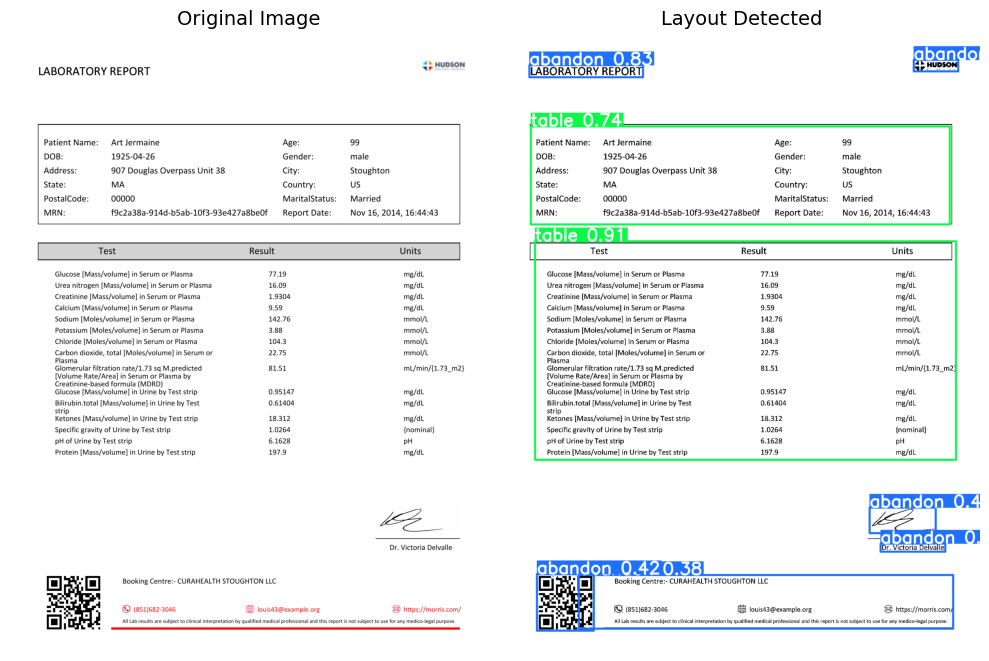

In [27]:
# Execute without interface

Image_path = "/Users/vidhipitroda/Desktop/Projects /Waivethewait/testing images/63.png" # provide the .png file path
question = "what is the patient's glucose level?"  # ask a question 

original_image = Image.open(Image_path)
layout_image, output = Document_image_analysis(original_image, question)

print("Question asked-", question)
print("Answer -", output)


# passing image as numpy arrays
%matplotlib inline
imgs = [original_image, layout_image]
titles = ["Original Image", "Layout Detected"]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 10))  # Only 2 subplots

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=14)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()